# Defining the Question

### a) Specifying the Question

> Mchezopesa Ltd requires a prediction result model of a game between team 1 and team 2, based on who's home and who's away, and on whether or not the game is friendly (include rank in your training).

### b) Defining the Metric for Success


> The metric of success if we can create a model that can predict a football match result between two teams given the input: Home team, Away Team and whether the game is friendly or not.

### c) Understanding the context


> Mchezopesa Ltd will greatly benefit from being able to predict football results as they will be able to tailor the odds of football games that they offer on the betting platform.

### d) Recording the Experimental Design


> The following deign was used:

*   Data importation
*   Data Reading & Cleaning
*   EDA
*   Feature Engineering
*   Checking multicolinearity
*   Model Building
*   Evaluating/Assessing Model
*   Prediction

### e) Data Relevance

> This was evaluated against the metric of success (after implementation of solution)

# Data Reading & Cleaning

## Importing the libraries

In [129]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


## Importing the dataset

In [132]:
#load 1st dataset
rank = pd.read_csv('fifa_ranking.csv')


In [133]:
#check head
rank.head()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
0,1,Germany,GER,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
1,2,Italy,ITA,0.0,57,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
2,3,Switzerland,SUI,0.0,50,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
3,4,Sweden,SWE,0.0,55,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,UEFA,1993-08-08
4,5,Argentina,ARG,0.0,51,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONMEBOL,1993-08-08


In [134]:
#check tail
rank.tail()

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
57788,206,Anguilla,AIA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57789,206,Bahamas,BAH,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CONCACAF,2018-06-07
57790,206,Eritrea,ERI,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,2018-06-07
57792,206,Tonga,TGA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OFC,2018-06-07


In [147]:
#check number of records
rank.shape

(5253, 17)

In [136]:
#load 2nd dataset
results = pd.read_csv('results.csv')


In [137]:
#check head
results.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [138]:
#check tail
results.tail()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
40834,2019-07-18,American Samoa,Tahiti,8,1,Pacific Games,Apia,Samoa,True
40835,2019-07-18,Fiji,Solomon Islands,4,4,Pacific Games,Apia,Samoa,True
40836,2019-07-19,Senegal,Algeria,0,1,African Cup of Nations,Cairo,Egypt,True
40837,2019-07-19,Tajikistan,North Korea,0,1,Intercontinental Cup,Ahmedabad,India,True
40838,2019-07-20,Papua New Guinea,Fiji,1,1,Pacific Games,Apia,Samoa,True


In [148]:
#check number of records
results.shape

(40839, 9)

> Merge the 2 datasets

In [139]:
#to merge we will need the year column
#we'll also need the month column since the ranking of a team at the end of the year is what counts in this case as
#ranking of the team in a particular year
#convert rank_date into datetime
import datetime
rank['rank_date']= pd.to_datetime(rank['rank_date'])

In [140]:
#create a new month column
rank['month'] = pd.DatetimeIndex(rank['rank_date']).month

In [141]:
#creating a new year column
rank['year'] = pd.DatetimeIndex(rank['rank_date']).year

#drop rank_date column
rank.drop('rank_date', axis=1, inplace= True)

In [142]:
#taking only the records/rankings at end of year (month 12)
rank_y = rank[rank['month'] == 12]

#getting 2018 rankings since the last date was June 2018
rank_ly = rank[(rank['month'] == 6) & (rank['year'] == 2018)]



frames = [rank_y, rank_ly]
rank = pd.concat(frames)
rank.tail(2)

,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,month,year
57791,206,Somalia,SOM,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CAF,6,2018
57792,206,Tonga,TGA,0.0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,OFC,6,2018


In [ ]:
#using country name and year from the rank dataset to merge onto the results dataset.
#minimise the rank dataset to relevant columns only
rank_r = rank.drop(rank.iloc[:,2:-1], axis=1)
rank_r.rename(columns = {'country_full':'home_team'}, inplace = True) 


In [ ]:
#results dataframe
#convert date into datetime
import datetime
results['date']= pd.to_datetime(results['date'])

#creating a new year column
results['year'] = pd.DatetimeIndex(results['date']).year

#drop rank_date column
results.drop('date', axis=1, inplace= True)


In [145]:
#merge both datasets based on country name, year (to add rank to our results dataset)
games = pd.merge(results, rank_r, how="right", on=["home_team", "year"])

#renaming rank column to home team rank
games.rename(columns = {'rank':'home_team_rank'}, inplace = True) 
games.tail(4)

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,home_team_rank
21381,Bahamas,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,206
21382,Eritrea,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,206
21383,Somalia,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,206
21384,Tonga,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018,206


In [146]:
#checking shape of the new dataframe
games.shape

(21385, 10)

In [149]:
#including the ranking of the away team
#using country name and year from the rank dataset to merge onto the results dataset.
#minimise the rank dataset to relevant columns only
rank_a = rank.drop(rank.iloc[:,2:-1], axis=1)
rank_a.rename(columns = {'country_full':'away_team'}, inplace = True) 


In [332]:
#merge both datasets based on country name, year (to add rank to our results dataset)
games_new = pd.merge(games, rank_a, how="right", on=["away_team", "year"])

#renaming rank column to home team rank
games_new.rename(columns = {'rank':'away_team_rank'}, inplace = True) 


In [197]:
#checking shape of the new dataframe
games_new.shape

(19526, 11)

> Data preparation

In [152]:
#checking column types
games_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19526 entries, 0 to 19525
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_team       18436 non-null  object 
 1   away_team       19526 non-null  object 
 2   home_score      18436 non-null  float64
 3   away_score      18436 non-null  float64
 4   tournament      18436 non-null  object 
 5   city            18436 non-null  object 
 6   country         18436 non-null  object 
 7   neutral         18436 non-null  object 
 8   year            19526 non-null  int64  
 9   home_team_rank  18436 non-null  float64
 10  away_team_rank  19526 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 1.8+ MB


In [153]:
#checking summary stats
games_new.describe()

,home_score,away_score,year,home_team_rank,away_team_rank
count,18436.000000,18436.000000,19526.000000,18436.000000,19526.000000
mean,1.606802,1.066121,2006.064785,74.106476,81.187135
std,1.623276,1.247605,7.260103,50.158980,53.485693
min,0.000000,0.000000,1993.000000,1.000000,1.000000
25%,0.000000,0.000000,2000.000000,32.000000,36.000000
50%,1.000000,1.000000,2006.000000,68.000000,74.500000
75%,2.000000,2.000000,2012.000000,110.000000,120.000000
max,31.000000,15.000000,2018.000000,207.000000,209.000000


In [154]:
#checking for nulls
games_new.isnull().sum()

home_team         1090
away_team            0
home_score        1090
away_score        1090
tournament        1090
city              1090
country           1090
neutral           1090
year                 0
home_team_rank    1090
away_team_rank       0
dtype: int64

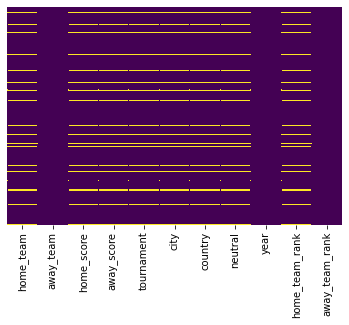

In [155]:
#visually looking at the nulls in the dataset
sns.heatmap(games_new.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [333]:
#since the nulls aren't too many in the dataset we can drop all
games_new.dropna(inplace=True)

In [158]:
#checking for nulls
games_new.isnull().sum()

home_team         0
away_team         0
home_score        0
away_score        0
tournament        0
city              0
country           0
neutral           0
year              0
home_team_rank    0
away_team_rank    0
dtype: int64

In [204]:
#checking shape again
games_new.shape

(18436, 11)

> about 1000 records were dropped due to having nulls.

In [161]:
games_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18436 entries, 0 to 19520
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   home_team       18436 non-null  object 
 1   away_team       18436 non-null  object 
 2   home_score      18436 non-null  float64
 3   away_score      18436 non-null  float64
 4   tournament      18436 non-null  object 
 5   city            18436 non-null  object 
 6   country         18436 non-null  object 
 7   neutral         18436 non-null  object 
 8   year            18436 non-null  int64  
 9   home_team_rank  18436 non-null  float64
 10  away_team_rank  18436 non-null  int64  
dtypes: float64(3), int64(2), object(6)
memory usage: 1.7+ MB


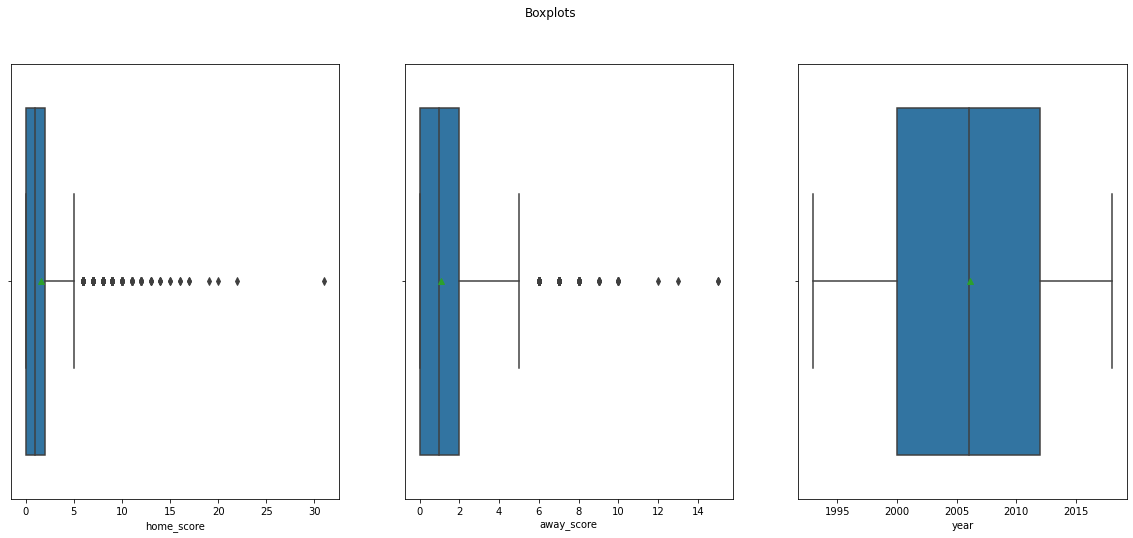

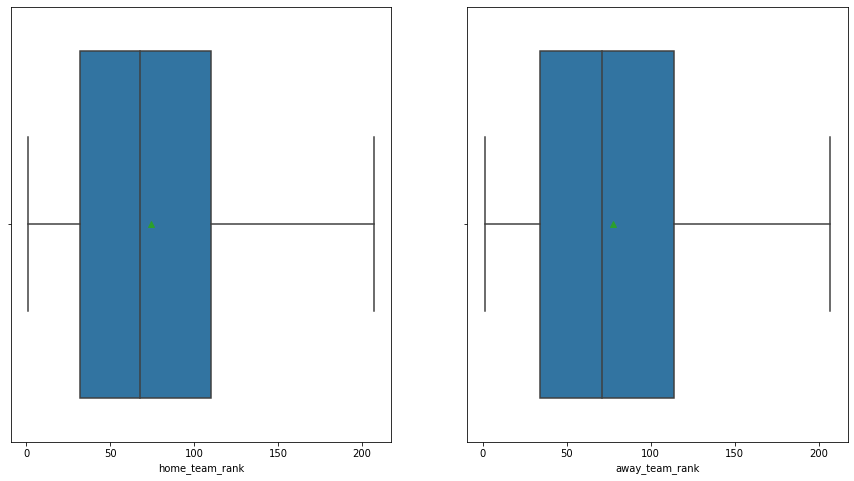

In [166]:
#checking for Outliers and Anomalies in the numerical columns
fig, (ax1, ax2,ax3) = plt.subplots(1,3, figsize=(20, 8))
fig.suptitle('Boxplots')
sns.boxplot(x = games_new['home_score'], ax=ax1, showmeans = True)
sns.boxplot(x = games_new['away_score'], ax=ax2, showmeans = True)
sns.boxplot(x = games_new['year'], ax=ax3, showmeans = True)

fig, (ax4,ax5) = plt.subplots(1,2, figsize=(15, 8))
sns.boxplot(x = games_new['home_team_rank'], ax=ax4, showmeans = True)
sns.boxplot(x = games_new['away_team_rank'], ax=ax5, showmeans = True)
plt.show()

In [334]:
#Dealing with anomalies
def outlier_determination(d_column):
 sorted(d_column)
 Q1,Q3 = np.percentile(d_column, [25,75])
 IQR = Q3 - Q1
 lower_range = Q1 - (1.5 * IQR)
 upper_range = Q3 + (1.5 * IQR)
 return lower_range,upper_range

#getting the bounds
#going by the boxplots we choose the columns with visible outliers
# home_score
lowerbound,upperbound = outlier_determination(games_new.home_score)
print(lowerbound,upperbound)

#removing outliers
games_new.drop(games_new[ (games_new.home_score > upperbound) | (games_new.home_score < lowerbound) ].index , inplace=True)


#away_score'
lowerbound,upperbound = outlier_determination(games_new.away_score)
print(lowerbound,upperbound)

#removing outliers
games_new.drop(games_new[ (games_new.away_score > upperbound) | (games_new.away_score < lowerbound) ].index , inplace=True)

#show new shape
games_new.shape


-3.0 5.0
-3.0 5.0


(17791, 11)

# Exploratory Data Analysis

In [212]:
# Ploting the univariate summaries and recording our observations
#
games_new.describe()

,home_score,away_score,year,home_team_rank,away_team_rank
count,17791.000000,17791.000000,17791.000000,17791.000000,17791.000000
mean,1.463437,1.025462,2006.174302,73.632736,76.016862
std,1.279755,1.104222,7.233061,49.605136,50.275404
min,0.000000,0.000000,1993.000000,1.000000,1.000000
25%,0.000000,0.000000,2000.000000,32.000000,34.000000
50%,1.000000,1.000000,2007.000000,67.000000,70.000000
75%,2.000000,2.000000,2012.000000,109.000000,111.000000
max,5.000000,5.000000,2018.000000,207.000000,207.000000


In [213]:
#Measures of central tendency and dispersion
#home score
print(f'Min: {games_new.home_score.min()}')
print(f'Q1: {games_new.home_score.quantile(.25)}')
print(f'Q2: {games_new.home_score.quantile(.50)}')
print(f'Q3: {games_new.home_score.quantile(.75)}')
print(f'Max: {games_new.home_score.max()}')
print('*'*15)

print(f'Mean: {games_new.home_score.mean()}')
print(f'Median: {games_new.home_score.median()}')
print(f'Mode: {games_new.home_score.mode().values[0]}')
print('*'*15)

print(f'Skew: {games_new.home_score.skew()}')
print(f'Kurtosis: {games_new.home_score.kurt()}')

Min: 0.0
Q1: 0.0
Q2: 1.0
Q3: 2.0
Max: 5.0
***************
Mean: 1.4634365690517677
Median: 1.0
Mode: 1.0
***************
Skew: 0.7608402674806152
Kurtosis: -0.006104978602707423


In [214]:
#Measures of central tendency and dispersion
#away score
print(f'Min: {games_new.away_score.min()}')
print(f'Q1: {games_new.away_score.quantile(.25)}')
print(f'Q2: {games_new.away_score.quantile(.50)}')
print(f'Q3: {games_new.away_score.quantile(.75)}')
print(f'Max: {games_new.away_score.max()}')
print('*'*15)

print(f'Mean: {games_new.away_score.mean()}')
print(f'Median: {games_new.away_score.median()}')
print(f'Mode: {games_new.away_score.mode().values[0]}')
print('*'*15)

print(f'Skew: {games_new.away_score.skew()}')
print(f'Kurtosis: {games_new.away_score.kurt()}')

Min: 0.0
Q1: 0.0
Q2: 1.0
Q3: 2.0
Max: 5.0
***************
Mean: 1.0254623124051487
Median: 1.0
Mode: 0.0
***************
Skew: 1.1264433843263724
Kurtosis: 1.0241702185953026


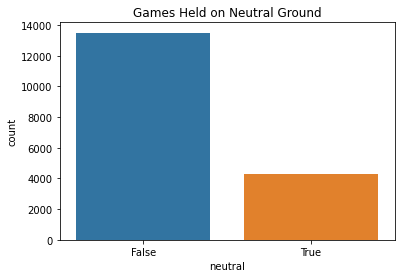

In [219]:
#Count plots
sns.countplot(x='neutral',data=games_new)
plt.title('Games Held on Neutral Ground')
plt.show()

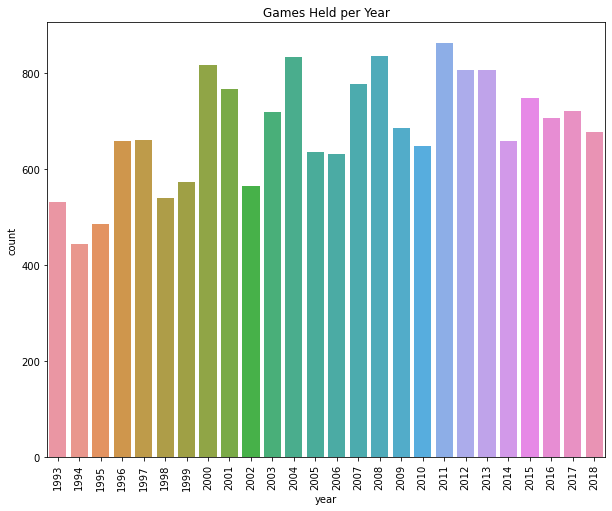

In [234]:
#Count plots
plt.figure(figsize = [10,8])
sns.countplot(x='year',data=games_new)
plt.title('Games Held per Year')
plt.xticks(rotation = 90)
plt.show()


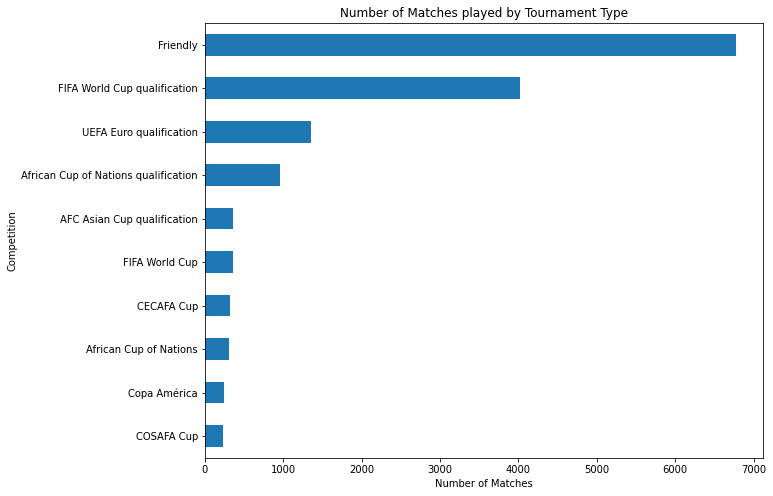

In [245]:
#Tournaments Top 10
plt.figure(figsize = [10,8])
top_10 = games_new['tournament'].value_counts().sort_values(ascending=False).head(10)
top_10.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of Matches')
plt.ylabel('Competition')
plt.title('Number of Matches played by Tournament Type')
plt.show()

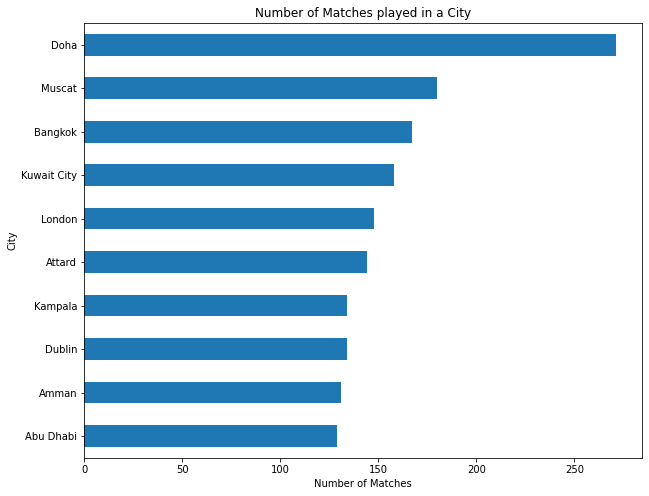

In [249]:
#Cities played in Top 10
plt.figure(figsize = [10,8])
top_10 = games_new['city'].value_counts().sort_values(ascending=False).head(10)
top_10.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of Matches')
plt.ylabel('City')
plt.title('Number of Matches played in a City')
plt.show()

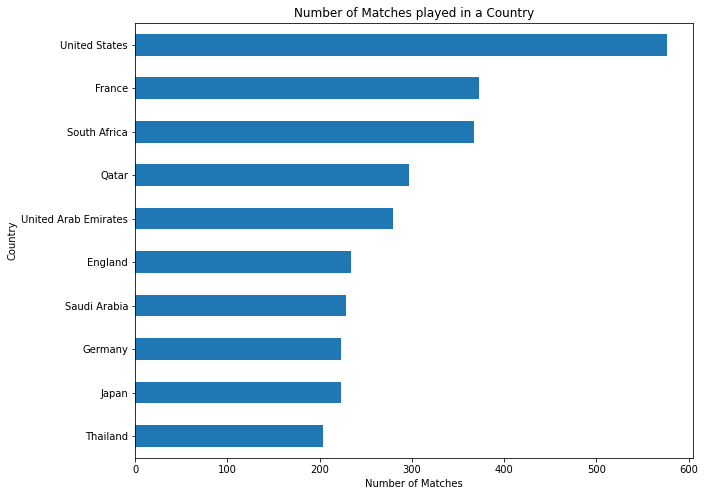

In [248]:
#Country played in Top 10
plt.figure(figsize = [10,8])
top_10 = games_new['country'].value_counts().sort_values(ascending=False).head(10)
top_10.sort_values(ascending=True).plot(kind='barh')
plt.xlabel('Number of Matches')
plt.ylabel('Country')
plt.title('Number of Matches played in a Country')
plt.show()

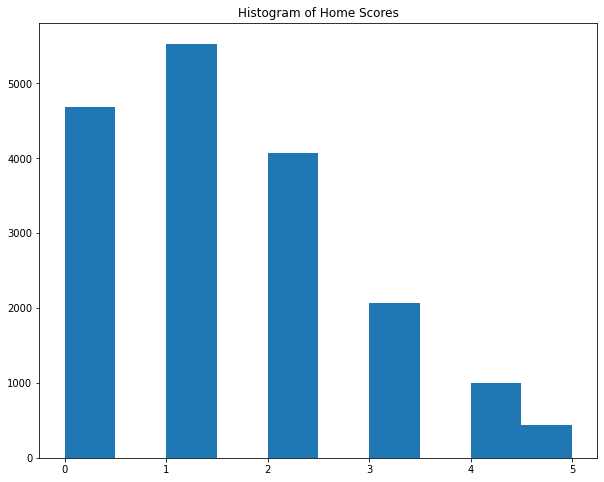

In [259]:
#Histogram of home scores
plt.figure(figsize = [10,8])
plt.hist(games_new['home_score'])
plt.title('Histogram of Home Scores')
plt.show()

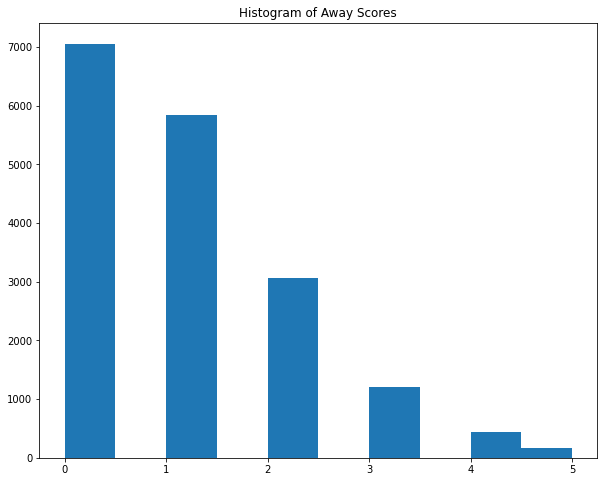

In [258]:
#Histogram of away scores
plt.figure(figsize = [10,8])
plt.hist(games_new['away_score'])
plt.title('Histogram of Away Scores')
plt.show()

In [285]:

#neut = pd.get_dummies(games_new['neutral'],drop_first=True)
#neut.rename(columns = {True:'neutral_encod'}, inplace = True)
#neut.head()

,neutral_encod
0,1
1,1
2,1
3,0
4,0


In [286]:
#games_d = pd.concat([games_new,neut],axis=1)
#games_d.head()

,home_team,away_team,home_score,away_score,tournament,city,country,neutral,year,home_team_rank,away_team_rank,neutral_encod
0,Brazil,Germany,3.0,3.0,USA Cup,Washington,United States,True,1993,3.0,1,1
1,Argentina,Germany,2.0,1.0,Friendly,Miami,United States,True,1993,8.0,1,1
2,England,Germany,1.0,2.0,USA Cup,Pontiac,United States,True,1993,11.0,1,1
3,Mexico,Germany,0.0,0.0,Friendly,Mexico City,Mexico,False,1993,16.0,1,0
4,Scotland,Germany,0.0,1.0,Friendly,Glasgow,Scotland,False,1993,24.0,1,0


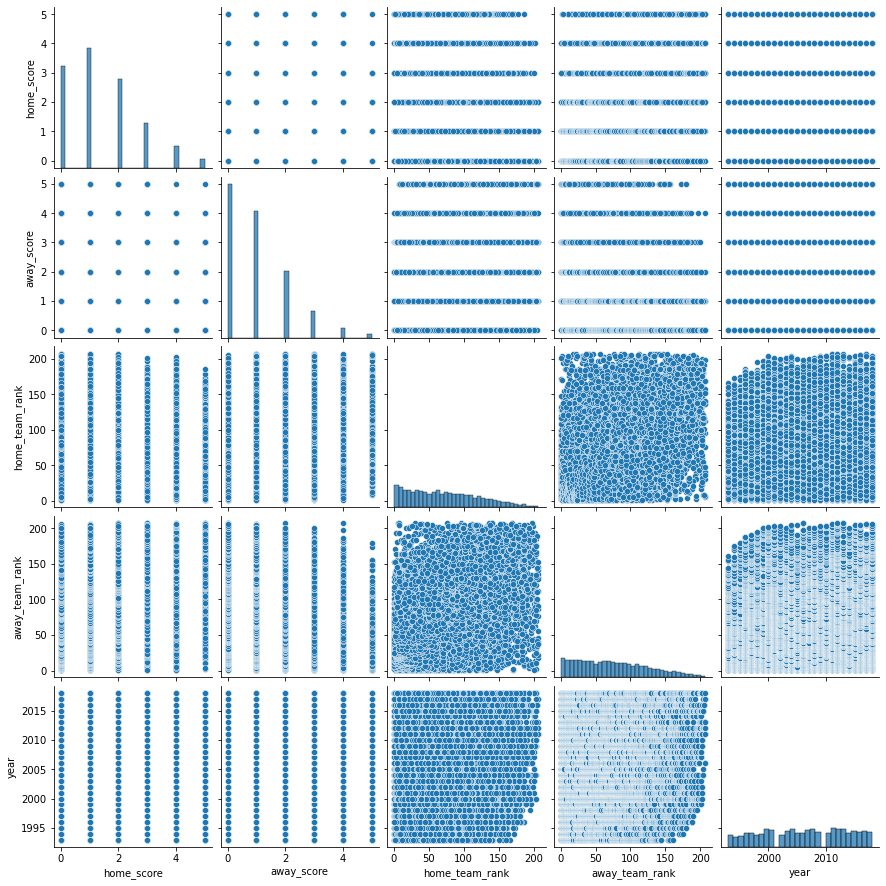

In [291]:
#bivariate summaries


sns.pairplot(games_new[['home_score', 'away_score', 'home_team_rank','away_team_rank', 'year']])

In [270]:
#Correlations
games_new.corr()


,home_score,away_score,year,home_team_rank,away_team_rank
home_score,1.000000,-0.129872,-0.029210,-0.183424,0.280154
away_score,-0.129872,1.000000,-0.006207,0.202905,-0.208231
year,-0.029210,-0.006207,1.000000,0.128877,0.133507
home_team_rank,-0.183424,0.202905,0.128877,1.000000,0.482783
away_team_rank,0.280154,-0.208231,0.133507,0.482783,1.000000


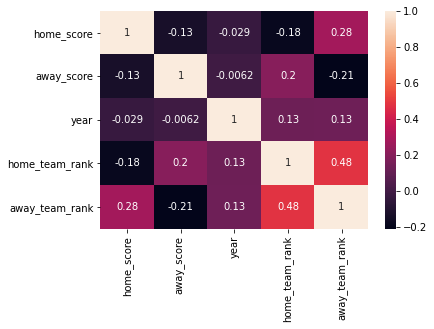

In [272]:
#correlation heatmap
sns.heatmap(games_new.corr(),annot=True)
plt.show()

# Feature Engineering

In [1009]:
#reset index
games_new.reset_index(drop=True, inplace=True)

#creating a copy to work on
games1 = games_new.copy(deep=True)


In [1010]:
#have tournament type as only World Cup, Friendly and Other
games1.tournament = games1.tournament.apply(lambda x: x.strip())
games1.tournament = games1.tournament.apply(lambda x: 'World Cup' if x == 'FIFA World Cup qualification' else ( 'World Cup' if x == 'FIFA World Cup' else ('Friendly' if x == 'Friendly' else 'Other')))


In [1011]:
#confirming the new tournament types
games1.tournament.unique()

array(['Other', 'Friendly', 'World Cup'], dtype=object)

In [1012]:
#checking value counts of same
games1.tournament.value_counts()

Friendly     6778
Other        6632
World Cup    4381
Name: tournament, dtype: int64

In [1013]:
#creating a new column of status of match based on home team
status = []
#x = ['Win', 'Loss', 'Draw']
for i in range(len(games1)):
    if games1.home_score.iloc[i] > games1.away_score.iloc[i]:
      status.append('Win')
    elif games1.home_score.iloc[i] < games1.away_score.iloc[i]:
      status.append('Loss')
    else:
      status.append('Draw')

In [1014]:
#convert list do df
status_df = pd.DataFrame(status, columns= ['status'])
status_df

#appending as column
games1s = pd.concat([games1,status_df],axis=1)



In [1015]:
#encode tournament, neutral and status
#label encoding
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()

# apply le on categorical feature columns
games1s['tournament'] = le.fit_transform(games1s['tournament'])
games1s['neutral'] = le.fit_transform(games1s['neutral'])
games1s['home_team'] = le.fit_transform(games1s['home_team'])
games1s['away_team'] = le.fit_transform(games1s['away_team'])




In [1016]:
#encoding status to maintain order
games1s['status'] = games1s['status'].replace(['Win','Draw','Loss'],[2, 1, 0])

# Checking Multicollinearity

In [1017]:
#multicollinearity test

# Remove the binnedinc, state, target_deathrate columns, we want to focus on our independent variables only.
games1s_c = games1s.drop(columns=['home_team', 'away_team', 'city', 'country'])

# Let's display the correlations between the variables
correlations = games1s_c.corr()

correlations

,home_score,away_score,tournament,neutral,year,home_team_rank,away_team_rank,status
home_score,1.000000,-0.129872,0.026331,-0.047363,-0.029210,-0.183424,0.280154,0.652948
away_score,-0.129872,1.000000,0.019374,0.073350,-0.006207,0.202905,-0.208231,-0.650241
tournament,0.026331,0.019374,1.000000,-0.019073,-0.027027,0.004199,-0.021081,-0.004481
neutral,-0.047363,0.073350,-0.019073,1.000000,0.032930,0.003020,0.025278,-0.076125
year,-0.029210,-0.006207,-0.027027,0.032930,1.000000,0.128877,0.133507,-0.017805
home_team_rank,-0.183424,0.202905,0.004199,0.003020,0.128877,1.000000,0.482783,-0.248903
away_team_rank,0.280154,-0.208231,-0.021081,0.025278,0.133507,0.482783,1.000000,0.290929
status,0.652948,-0.650241,-0.004481,-0.076125,-0.017805,-0.248903,0.290929,1.000000


In [1018]:
#VIF test
pd.DataFrame(np.linalg.inv(correlations.values), index = correlations.index, columns=correlations.columns)


,home_score,away_score,tournament,neutral,year,home_team_rank,away_team_rank,status
home_score,2.543196,-1.347618,-0.062398,0.057463,0.039555,0.440887,-0.556376,-2.260447
away_score,-1.347618,2.466163,0.007183,-0.082800,0.012922,-0.392451,0.424651,2.256257
tournament,-0.062398,0.007183,1.003666,0.016164,0.023843,-0.034042,0.044181,0.030239
neutral,0.057463,-0.082800,0.016164,1.015641,-0.028106,0.091441,-0.110861,0.040540
year,0.039555,0.012922,0.023843,-0.028106,1.027333,-0.067743,-0.116221,0.015784
home_team_rank,0.440887,-0.392451,-0.034042,0.091441,-0.067743,1.765030,-1.117372,0.226936
away_team_rank,-0.556376,0.424651,0.044181,-0.110861,-0.116221,-1.117372,1.858159,-0.189611
status,-2.260447,2.256257,0.030239,0.040540,0.015784,0.226936,-0.189611,4.058215


> The dataset features have an acceptable range of multicollinearity so there's no need to drop any features 

# Implementing the Solution

## Polynomial Regression

### Training the Polynomial Regression model on the whole dataset

> Model 1: Home Goals

In [1020]:
#separating the data to features and label (model 1: Home scores)
#tournament Other = 1, Friendly = 0, WorldCup = 2
X = (games1s[['home_team_rank','away_team_rank','tournament']]).values
y = games1s.iloc[:, 2].values

In [1021]:
# Splitting the data
 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1022]:
#creating the model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 3)
X_poly = poly_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

### Predicting a new result with Polynomial Regression

In [1023]:
#Using X_test to predict
preds = lin_reg_2.predict(poly_reg.fit_transform(X_test))


In [1024]:
#printing out predicted home scores against test
np.set_printoptions(precision=2)
print(np.concatenate((preds.reshape(len(preds),1), y_test.reshape(len(y_test),1)),1))

[[2.1  2.  ]
 [2.25 3.  ]
 [1.44 2.  ]
 ...
 [1.57 1.  ]
 [2.12 2.  ]
 [0.86 0.  ]]


In [1025]:
#Evaluating Model
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R-Squared:', metrics.r2_score(y_test, preds))

Mean Absolute Error: 0.8977981523549321
Mean Squared Error: 1.2818509239234994
Root Mean Squared Error: 1.1321885549339825
R-Squared: 0.24158964299336183


> Adjusting degree and trying again

In [1026]:
#creating the model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 4)
X_poly = poly_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1027]:
#Using X_test to predict
preds = lin_reg_2.predict(poly_reg.fit_transform(X_test))

In [1028]:
#printing out predicted home scores against test
np.set_printoptions(precision=2)
print(np.concatenate((preds.reshape(len(preds),1), y_test.reshape(len(y_test),1)),1))

[[2.04 2.  ]
 [2.27 3.  ]
 [1.46 2.  ]
 ...
 [1.59 1.  ]
 [2.09 2.  ]
 [0.88 0.  ]]


In [1029]:
#Evaluating Model
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R-Squared:', metrics.r2_score(y_test, preds))


Mean Absolute Error: 0.897011121363725
Mean Squared Error: 1.2805285177683874
Root Mean Squared Error: 1.1316043998537595
R-Squared: 0.24237204795597367


> Through an iterative process on the code, the best accuracy was achieved using degree = 4 but the model is very poor, the RMSE is almost equal to the mean score.

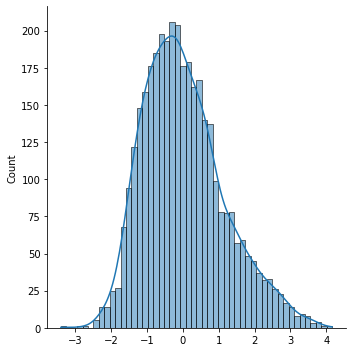

In [1030]:
#Residual Plot distribution
sns.displot((y_test-preds), bins = 50, kde = True)
plt.show()

> Model 2: Away Goals

> Training model 2

In [1031]:
#separating the data to features and label (model 2: Away scores)
#tournament Other = 1, Friendly = 0, WorldCup = 2
X = (games1s[['home_team_rank','away_team_rank', 'tournament']]).values
y = games1s.iloc[:, 3].values


In [1032]:
# Splitting the data
 
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [1033]:
#creating the model
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
poly_reg = PolynomialFeatures(degree = 5)
X_poly = poly_reg.fit_transform(X_train)
lin_reg_2 = LinearRegression()
lin_reg_2.fit(X_poly, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [1034]:
#Using X_test to predict
preds = lin_reg_2.predict(poly_reg.fit_transform(X_test))

In [1035]:
#printing out predicted home scores against test
np.set_printoptions(precision=2)
print(np.concatenate((preds.reshape(len(preds),1), y_test.reshape(len(y_test),1)),1))

[[0.53 1.  ]
 [0.5  0.  ]
 [0.97 2.  ]
 ...
 [0.76 1.  ]
 [0.57 2.  ]
 [1.49 1.  ]]


In [1036]:
#Evaluating Model
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, preds))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, preds))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R-Squared:', metrics.r2_score(y_test, preds))

Mean Absolute Error: 0.7797877557084185
Mean Squared Error: 0.9736345288099377
Root Mean Squared Error: 0.9867292074373484
R-Squared: 0.1719100562653555


> Through an iterative process on the code, the best accuracy was achieved using degree = 5 but the model is very poor, the RMSE is almost equal to the mean score.

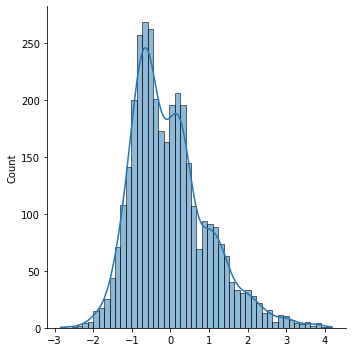

In [1037]:
#Residual Plot distribution
sns.displot((y_test-preds), bins = 50, kde = True)
plt.show()

## Logistic Regression

### Splitting the dataset into the Training set and Test set

In [1058]:
#defining the features and label
X = (games1s_c.drop(['away_score', 'neutral','status'], axis=1)).values
y = (games1s_c[ 'status']).values

#split the data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## Feature Scaling

In [1053]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### Training the Logistic Regression model on the Training set

In [1054]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Predicting the Test set results

In [1055]:
y_pred = classifier.predict(X_test)

### Making the Confusion Matrix

In [1056]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[ 687  189   97]
 [ 351  308  208]
 [  48  187 1484]]


In [1059]:
#Evaluating Model
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, preds)))
print('R-Squared:', metrics.r2_score(y_test, y_pred))

Mean Absolute Error: 0.3441978083731385
Mean Squared Error: 0.4256813711716774
Root Mean Squared Error: 1.2019493108480586
R-Squared: 0.4025156710007367


> The accuracy of this model is better than the Polynomial model but in general it would be better guessing than using this model since the R-squared is only 40%. To ensure a better performance we can use K-fold CV

### Computing the accuracy with k-Fold Cross Validation

In [1060]:
from sklearn.model_selection import cross_val_score
accuracies = cross_val_score(estimator = classifier, X = X_train, y = y_train, cv = 10)
print("Accuracy: {:.2f} %".format(accuracies.mean()*100))
print("Standard Deviation: {:.2f} %".format(accuracies.std()*100))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Accuracy: 67.81 %
Standard Deviation: 0.38 %


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


> Despite some convergence issues the thing to note is that the mean accuracy of model is 67.81% with a Standard Deviation of 0.38%, this means the model has a high bias but low variance and therefore would not perform well in prediction. We can go a step further and improve this by doing Hyperparameter optimization.

### HyperParameter Tuning

In [1062]:
# Creating regularization penalty space
penalty = ['l1', 'l2']

# Creating regularization hyperparameter space
C = np.logspace(0, 4, 10)

solver = [ 'liblinear', 'sag', 'saga']

max_iter=(50,100)
#np.arange(30,151,20)

# Creating hyperparameter options
hyperparameters = dict(C=C, penalty=penalty,  max_iter = max_iter, solver = solver)

In [1063]:
# Creating grid search using 5-fold cross validation
from sklearn.model_selection import GridSearchCV
clf = GridSearchCV(classifier, hyperparameters, cv=5, verbose=0)




In [1064]:
# Fitting grid search
best_model = clf.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

In [1065]:
#Showing the best model score
print(best_model.best_score_)

0.6819135725218765


In [1066]:
#showing the best model Hyperparameters we can use to improve the model
print(best_model.best_params_)

{'C': 2.7825594022071245, 'max_iter': 50, 'penalty': 'l1', 'solver': 'liblinear'}


> As shown the best performance by hyperparameter tuning was about 68% which is an additional 1% from the K-fold cross validation. The following HyperParameters were found to be otpimal for this particular model (LogisticRegression model used):

*   'C': 2.7825594022071245
*   'max_iter': 50
*   'penalty': 'l1'
*   'solver': 'liblinear'

# Challenging the Solution

> The model was not optimal, a way to improve the model is to find a way to incorporate time(Year) into the model which may improve the accuracy of the model

# Follow up questions

## a) Did we have the right data?


> From the model we had some of the relevant data but not sufficient.

## b) Do we need other data to answer our question?


> From the model, it seems we may have required some more independent models that would explain the target variable.

## c) Did we have the right question?

> The question was a good one but based on the data we had, we were not able to answer it with high confidence. The model is suspect.
